In [11]:
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np


In [12]:

#  CONFIG 
filename = "Spring 2025 CoT HS Administration respondent actions - Spring 2025 CoT HS Administration respondent actions.csv"
time_format = "%m/%d/%Y %H:%M:%S"  # adjust if needed

# LOAD CSV INTO DATAFRAME 
df = pd.read_csv(filename)
df.head()

,Assignment,Activities,Date,Time,Action
0,131786,Spr 25 CoT Form B1,05/09/2025,10:29:37,Begin activity Spring 2025 CoT HS Administration
1,131786,Spr 25 CoT Form B1,05/09/2025,10:29:37,Page 1 Loaded
2,131786,Spr 25 CoT Form B1,05/09/2025,10:29:43,Page next clicked on page 1
3,131786,Spr 25 CoT Form B1,05/09/2025,10:29:44,Page 2 Loaded
4,131786,Spr 25 CoT Form B1,05/09/2025,10:29:49,Page next clicked on page 2


In [13]:

# Merge Date + Time into one column
df["DateTime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format=time_format)


In [14]:

# Identify pause users 
pause_flags = df.groupby(["Assignment","Activities"])["Action"].apply(
    lambda x: any("Pause activity" in a for a in x)
).reset_index(name="HasPause")

# Get start/end times 
def get_times(group):
    start = group.loc[group["Action"].str.contains("Begin activity"), "DateTime"].min()
    end = group.loc[group["Action"].str.contains("End activity"), "DateTime"].max()
    return pd.Series({"Start": start, "End": end})

times = df.groupby(["Assignment","Activities"]).apply(get_times).reset_index()
times["Duration"] = times["End"] - times["Start"]

#  Keep only same-day exams 
times = times[times["Start"].dt.date == times["End"].dt.date]

# Merge and subset no-pause
merged = times.merge(pause_flags, on=["Assignment","Activities"])
no_pause = merged[merged["HasPause"] == False]

/var/folders/7d/5zcxdvbd72gcl3824lw5l6500000gn/T/ipykernel_42744/80169945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_pause["Hours"] = no_pause["Duration"].dt.total_seconds() / 3600
/var/folders/7d/5zcxdvbd72gcl3824lw5l6500000gn/T/ipykernel_42744/80169945.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_pause["Form"] = no_pause["Activities"].str.replace("Spr 25 CoT ", "", regex=False)


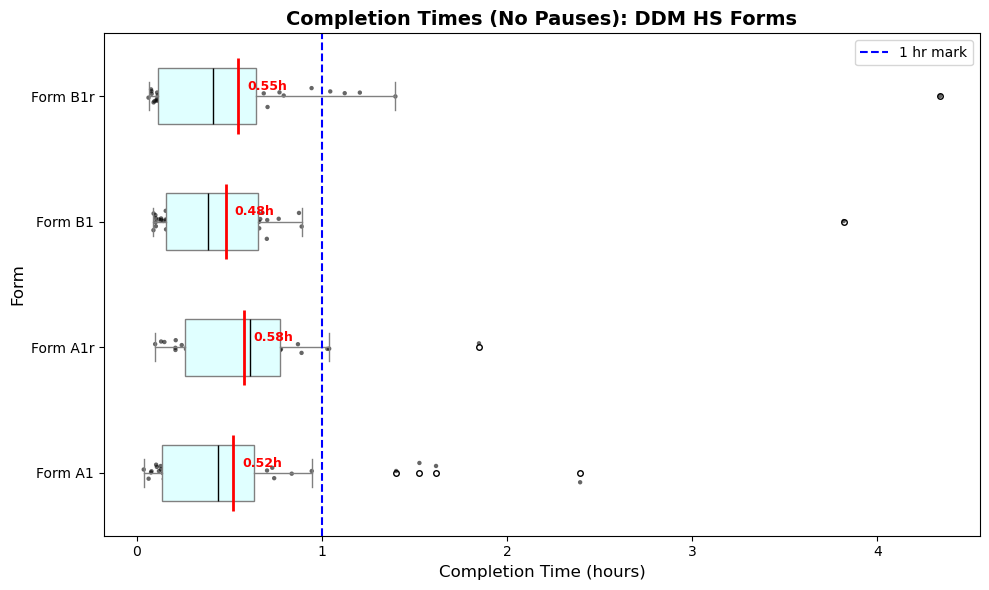

In [20]:


# --- Convert Duration to hours ---
no_pause["Hours"] = no_pause["Duration"].dt.total_seconds() / 3600

# --- Simplify form names (optional cleanup) ---
no_pause["Form"] = no_pause["Activities"].str.replace("Spr 25 CoT ", "", regex=False)

# --- Sort forms alphabetically (A, B, C, D...) ---
forms = sorted(no_pause["Form"].unique())

# --- Create boxplot ---
plt.figure(figsize=(10, 6))
plt.boxplot(
    [no_pause.loc[no_pause["Form"] == f, "Hours"] for f in forms],
    vert=False,
    labels=forms,
    patch_artist=True,
    boxprops=dict(facecolor="lightcyan", color="gray"),
    medianprops=dict(color="black"),
    whiskerprops=dict(color="gray"),
    capprops=dict(color="gray"),
    flierprops=dict(marker="o", markerfacecolor="none", markeredgecolor="black", markersize=4)
)

# --- Add scatter points for all individual observations ---
for i, form in enumerate(forms, start=1):
    y = np.random.normal(i, 0.04, size=len(no_pause.loc[no_pause["Form"] == form]))  # jitter for visibility
    x = no_pause.loc[no_pause["Form"] == form, "Hours"]
    plt.scatter(x, y, color='black', s=10, alpha=0.6, edgecolors='none')
    
# --- Add per-form vertical mean lines (like median) ---
for i, form in enumerate(forms, start=1):
    mean_val = no_pause.loc[no_pause["Form"] == form, "Hours"].mean()
    # Draw a vertical red line for the mean
    plt.vlines(x=mean_val, ymin=i-0.3, ymax=i+0.3, colors='red', linewidth=2, label='_nolegend_')
    # Add a label next to it
    plt.text(mean_val + 0.05, i + 0.05, f"{mean_val:.2f}h", color='red', fontsize=9, fontweight='bold')


# --- Add 1-hour reference line ---
plt.axvline(x=1, color='blue', linestyle='--', label='1 hr mark')


# --- Labels and title ---
plt.xlabel("Completion Time (hours)", fontsize=12)
plt.ylabel("Form", fontsize=12)
plt.title("Completion Times (No Pauses): DDM HS Forms", fontsize=14, weight="bold")
plt.legend()

plt.tight_layout()
plt.show()
